In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Step 1:
# Buat kelas yang mempermudah kita untuk mengambil output dari tiap layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        # Definisikan masing-masing layer
        # nn.Conv2d(# of input channel, # of output channel, # x # square convolution)
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        # Mengembalikan array yang berisi output dari tiap layer
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [3]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [4]:
# Get network yang udah di-download
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth')) # load model yang kita download
for param in vgg.parameters():
    param.requires_grad = False 
if torch.cuda.is_available(): # kalau ada CUDA, pakai CUDA
    vgg.cuda()

In [6]:
# Step 0
# Load gambar
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'pacil.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# Random init, or...
# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True)

# Mulai dari content image-nya
opt_img = Variable(content_image.data.clone(), requires_grad=True)

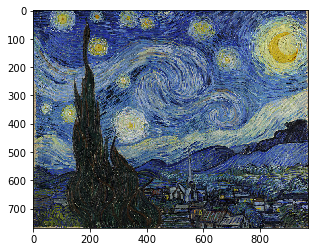

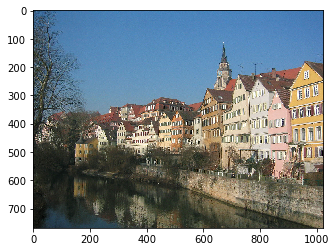

In [7]:
#display images
for img in imgs:
    imshow(img);show()

In [8]:
# Step 2
# Tentukan mana yang content layers, mana yang style layers, dan mana layers dari generated image kita

# Definisikan style layers, yaitu semua layer
style_layers = ['r11','r21','r31','r41', 'r51'] 

# Definisikan content layers, yaitu hanya higher layer saja yaitu r42
content_layers = ['r42']

# Loss layers adalah gabungan dari style layers dan content layers
loss_layers = style_layers + content_layers 

# Inisialisasi berat
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

# Step 3
# Tentuin mana yang style, mana yang konten

# Konten
content_targets = [A.detach() for A in vgg(content_image, content_layers)]

# Style
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)           # me-resize tensor
        G = torch.bmm(F, F.transpose(1,2))  # ingat bahwa Gram Matrix = matrix yang dikalikan dengan transpose-nya.
                                            # torch.bmm -> perkalian tensor
        G.div_(h*w)
        return G

style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
targets = style_targets + content_targets

In [ ]:
# Step 4
# Hitung content loss dan style loss

# Content loss
# No need, udah ada di pyTorch (nn.MSELoss()), bisa langsung pake :D

# Style loss
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target) # hitung mean squared error loss antara Gram Matrix 
                                                        # gambar referensi dan generated output
        return(out)
    
# Definisikan total loss function 
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)

if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]

Iteration: 50, loss: 1388532.500000
Iteration: 100, loss: 707860.750000
Iteration: 150, loss: 538045.437500
Iteration: 200, loss: 469374.875000
Iteration: 250, loss: 433804.625000
Iteration: 300, loss: 411657.562500
Iteration: 350, loss: 395248.250000
Iteration: 400, loss: 383885.312500
Iteration: 450, loss: 375128.750000
Iteration: 500, loss: 368493.781250


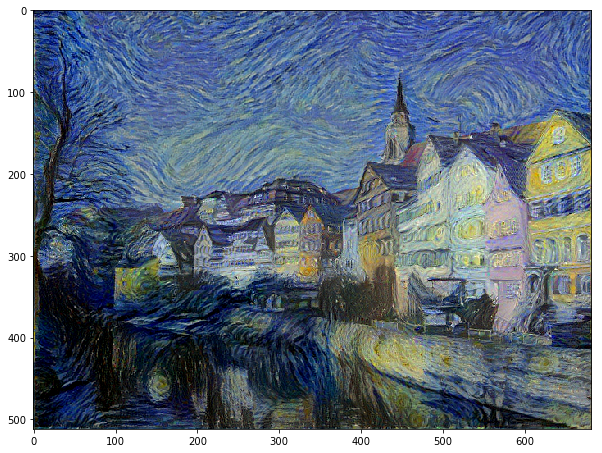

In [9]:
# Step 5
# Setup optimizer
max_iter = 500 # jumlah maksimal iterasi. Jadi, kalau jumlah iterasi sudah sampai 500, maka akan
               # berhenti
show_iter = 50 # tampilkan progress iterasi setiap 50 iterasi
optimizer = optim.LBFGS([opt_img]); # gunakan optimizer LBFGS
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad() # clears x.grad biar gradients-nya gak keakumulasi
        out = vgg(opt_img, loss_layers) 
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward() # Hitung gradien
        n_iter[0]+=1
        
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0])) # Bakal ngeprint jaraknya udah berapa
        return loss
    
    optimizer.step(closure)
    
# Print gambar
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)